# walkthrough of c/d/r vine copula (vinecop) quantile regression/ conditional simulation.
Simulation workflow arrangement depends on constructed vine structure. During vine construction, user may indicate `lst_first` to place certain vertices at shallower levels.

- Full Simulation, as in `1_vinecop.ipynb`
- Quantile Regression, user may give values to `D-1` variables (at top lv) and explore the one at deepest lv.
- Conditional Simulation, user may give values to some variables and sim the rest.

cuda (GPU) avail? True

full simulation/ quantile-regression/ conditional-simulation using the vine copula. Sequentially for each beginning vertex in the lst_sim (from right to left, as from shallower lv to deeper lv in the DAG), walk upward by calling hinv until the top vertex (whose cond set is empty) is reached. (Recursively) call hfunc for the other upper vertex if necessary.

        :param num_sim: number of simulations; ignored when dct_first_vs is not empty
        :type num_sim: int
        :param dct_first_vs: dict of {(vertex,cond_set): torch.Tensor(size=(n,1))} in quantile regression/ conditional simulation, where vertices are taken as given already; defaults to {}
        :type dct_first_vs: dict, optional
        :param lst_sim: list of vertices (read from right to left) in a full simulation workflow, gives flexibility to experienced users, defaults to []
        :type lst_sim: list, optional
        :param seed: random seed for torch.manual_seed(), defaults to 0
        

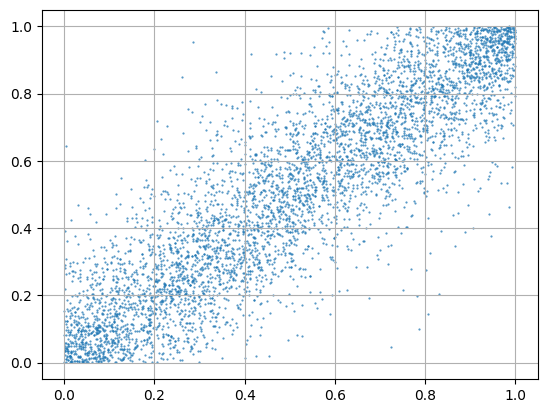

In [1]:
import sys
import matplotlib.pyplot as plt
import torch

# * add proj root folder into path so `./tests` folder is searchable
sys.path.append("..")
import torchvinecopulib as tvc

# * a helper function to sim vinecop obs
from tests import sim_vcp_from_bcp

print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_SIM, NUM_DIM = 5000, 7
# simulate multivariate copula data from bicop
V_mvcp = sim_vcp_from_bcp(
    bcp_tvc=tvc.bicop.Frank,
    num_sim=NUM_SIM,
    num_dim=NUM_DIM,
    device=DEVICE,
)[:, range(NUM_DIM - 1, -1, -1)]
# visualize first two dim
plt.scatter(*V_mvcp[:, [1, 2]].T.cpu(), s=0.3, alpha=0.8)
plt.grid()
print(tvc.vinecop.DataVineCop.sim.__doc__)

## cvine

### cvine full sim

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 5_000,
 'num_par': 7,
 'negloglik': -12929.4934,
 'aic': -25844.9868,
 'bic': -25799.3664,
 'matrix': '[[ 0  3  2  6  1  4  5]'
           ' [-1  2  3  6  1  4  5]'
           ' [-1 -1  3  6  1  4  5]'
           ' [-1 -1 -1  1  6  4  5]'
           ' [-1 -1 -1 -1  4  6  5]'
           ' [-1 -1 -1 -1 -1  5  6]'
           ' [-1 -1 -1 -1 -1 -1  6]]',
 'lst_sim': [0, 3, 2, 6, 1, 4, 5]}


tensor([[0.5803, 0.7129, 0.7297,  ..., 0.9397, 0.8805, 0.7328],
        [0.8853, 0.6570, 0.5644,  ..., 0.8924, 0.5873, 0.6851],
        [0.6481, 0.5426, 0.4444,  ..., 0.3868, 0.3703, 0.3232],
        ...,
        [0.9884, 0.3929, 0.4782,  ..., 0.5687, 0.6473, 0.6783],
        [0.6058, 0.4720, 0.4405,  ..., 0.5730, 0.1042, 0.1089],
        [0.1395, 0.4842, 0.5366,  ..., 0.6504, 0.1959, 0.0733]],
       device='cuda:0', dtype=torch.float64)

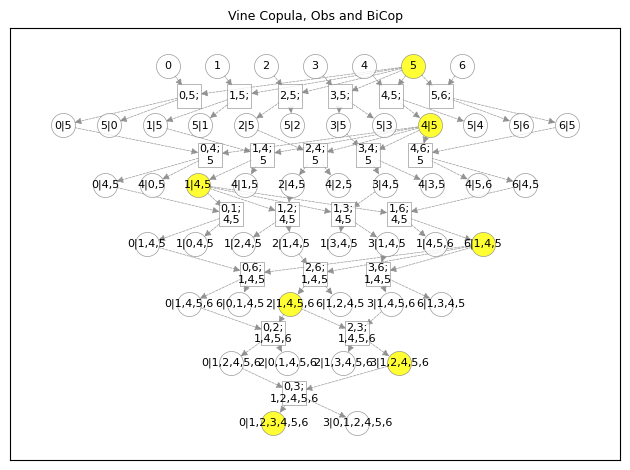

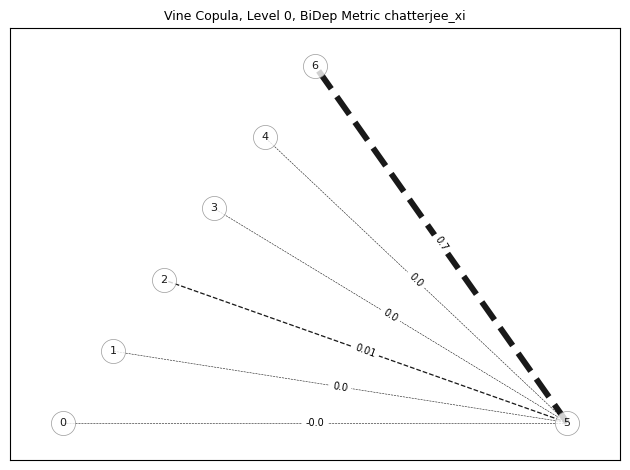

In [2]:
# full sim
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, cdrvine='cvine')
print(tvc_mdl)
tvc_mdl.draw_dag()
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE)

### cvine quant reg
> cvine
> 
> suppose we leave `0` at the deepest lv; specify values for all other vertices and explore its cond quantile from 0 to 1.

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 5_000,
 'num_par': 7,
 'negloglik': -12929.4934,
 'aic': -25844.9868,
 'bic': -25799.3664,
 'matrix': '[[ 0  3  2  6  1  4  5]'
           ' [-1  2  3  6  1  4  5]'
           ' [-1 -1  3  6  1  4  5]'
           ' [-1 -1 -1  1  6  4  5]'
           ' [-1 -1 -1 -1  4  6  5]'
           ' [-1 -1 -1 -1 -1  5  6]'
           ' [-1 -1 -1 -1 -1 -1  6]]',
 'lst_sim': [0, 3, 2, 6, 1, 4, 5]}


tensor([[0.0000e+00, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [2.1166e-04, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [4.1980e-04, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        ...,
        [9.9960e-01, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [9.9980e-01, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [1.0000e+00, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01]], device='cuda:0')

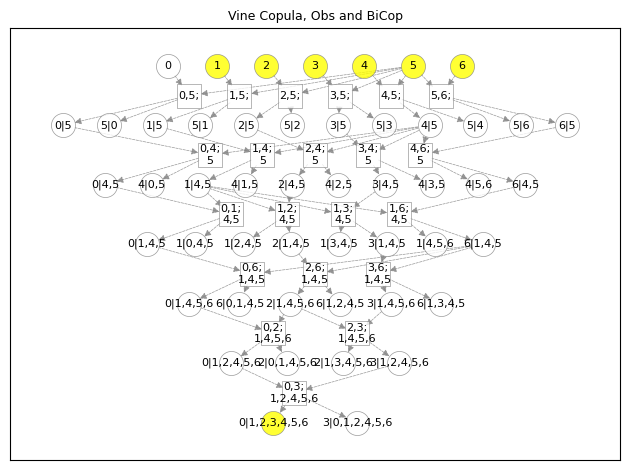

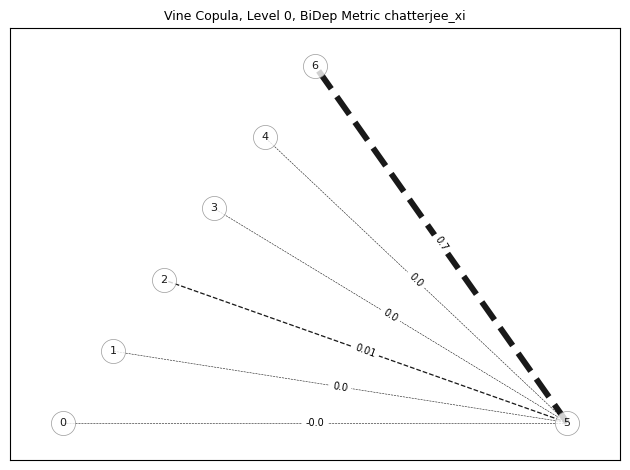

In [3]:
# quant-reg
lst_first = [_ for _ in range(1, NUM_DIM)]
dct_first_vs = {
    (_, frozenset()): torch.ones([NUM_SIM, 1], device=DEVICE) * _ / 10 for _ in range(1, NUM_DIM)
}
dct_first_vs[(0, frozenset(range(1, NUM_DIM)))] = torch.linspace(
    0, 1, NUM_SIM, device=DEVICE
).reshape(-1, 1)
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, cdrvine="cvine", lst_first=lst_first)
print(tvc_mdl)
tvc_mdl.draw_dag(lst_first_vs=dct_first_vs.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs)

### cvine cond sim
> cvine
> 
> suppose we leave `[0,1]` at the deepest lv; specify values for all other vertices.

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 5_000,
 'num_par': 6,
 'negloglik': -12928.1318,
 'aic': -25844.2635,
 'bic': -25805.1604,
 'matrix': '[[ 0  1  6  3  2  4  5]'
           ' [-1  1  6  3  2  4  5]'
           ' [-1 -1  3  6  2  4  5]'
           ' [-1 -1 -1  2  6  4  5]'
           ' [-1 -1 -1 -1  4  6  5]'
           ' [-1 -1 -1 -1 -1  5  6]'
           ' [-1 -1 -1 -1 -1 -1  6]]',
 'lst_sim': [0, 1, 6, 3, 2, 4, 5]}


tensor([[0.9392, 0.3808, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.0674, 0.2856, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.6629, 0.2287, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        ...,
        [0.9285, 0.3094, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.9222, 0.4765, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.0031, 0.1946, 0.2000,  ..., 0.4000, 0.5000, 0.6000]],
       device='cuda:0', dtype=torch.float64)

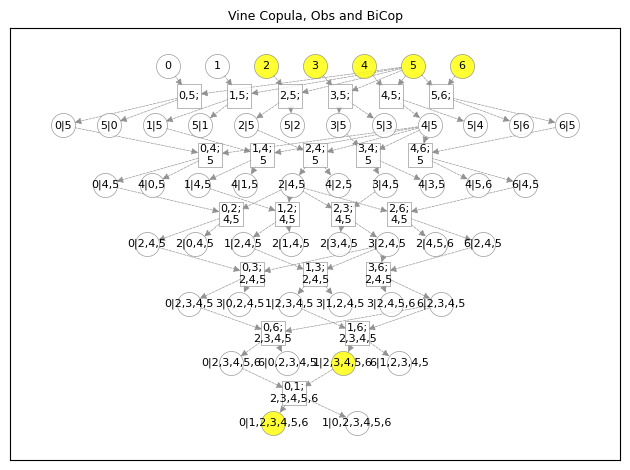

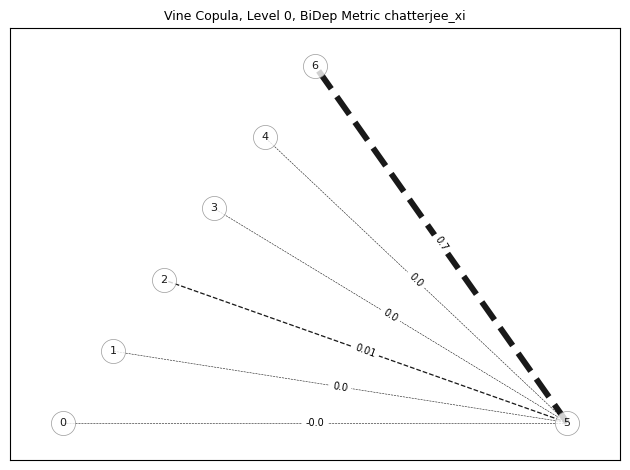

In [4]:
# quant-reg
lst_first = [_ for _ in range(2, NUM_DIM)]
dct_first_vs = {
    (_, frozenset()): torch.ones([NUM_SIM, 1], device=DEVICE) * _ / 10 for _ in range(2, NUM_DIM)
}
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, cdrvine="cvine", lst_first=lst_first)
print(tvc_mdl)
tvc_mdl.draw_dag(lst_first_vs=dct_first_vs.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs)

## dvine

### dvine full sim

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 5_000,
 'num_par': 9,
 'negloglik': -12936.3147,
 'aic': -25854.6294,
 'bic': -25795.9746,
 'matrix': '[[ 0  6  5  2  1  4  3]'
           ' [-1  3  6  5  2  1  4]'
           ' [-1 -1  4  6  5  2  1]'
           ' [-1 -1 -1  1  6  5  2]'
           ' [-1 -1 -1 -1  2  6  5]'
           ' [-1 -1 -1 -1 -1  5  6]'
           ' [-1 -1 -1 -1 -1 -1  6]]',
 'lst_sim': [0, 3, 4, 1, 2, 5, 6]}


tensor([[0.0000, 0.4773, 0.7129,  ..., 0.5729, 1.0000, 0.8805],
        [0.8869, 0.8024, 0.6570,  ..., 0.2561, 0.7065, 0.5873],
        [0.6489, 0.4673, 0.5426,  ..., 0.2553, 0.3445, 0.3703],
        ...,
        [0.9884, 0.4429, 0.3929,  ..., 0.7165, 0.6629, 0.6473],
        [0.6026, 0.4657, 0.4720,  ..., 0.4126, 0.1270, 0.1042],
        [0.1391, 0.2648, 0.4842,  ..., 0.6547, 0.2318, 0.1959]],
       device='cuda:0', dtype=torch.float64)

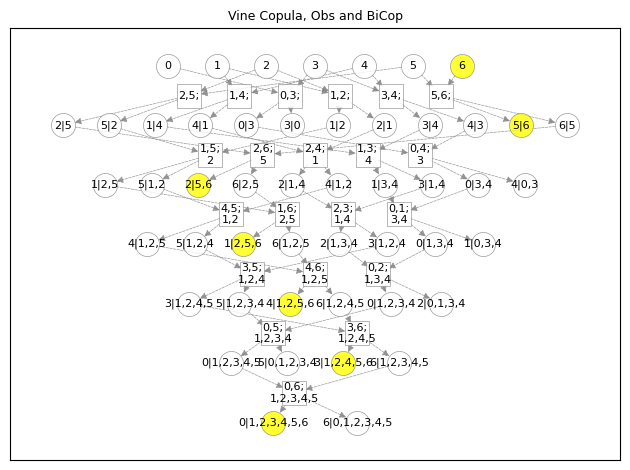

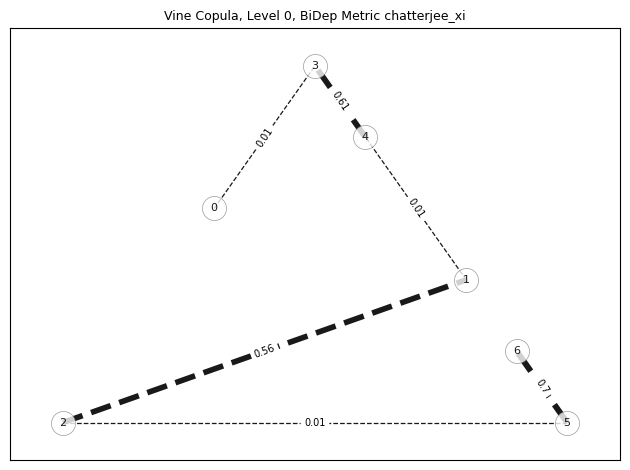

In [5]:
# full sim
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, cdrvine='dvine')
print(tvc_mdl)
tvc_mdl.draw_dag()
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE)

### dvine quant reg
> dvine
> 
> suppose we leave `0` at the deepest lv; specify values for all other vertices and explore its cond quantile from 0 to 1.

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 5_000,
 'num_par': 9,
 'negloglik': -12936.3147,
 'aic': -25854.6294,
 'bic': -25795.9746,
 'matrix': '[[ 0  6  5  2  1  4  3]'
           ' [-1  3  6  5  2  1  4]'
           ' [-1 -1  4  6  5  2  1]'
           ' [-1 -1 -1  1  6  5  2]'
           ' [-1 -1 -1 -1  2  6  5]'
           ' [-1 -1 -1 -1 -1  5  6]'
           ' [-1 -1 -1 -1 -1 -1  6]]',
 'lst_sim': [0, 3, 4, 1, 2, 5, 6]}


tensor([[0.0000e+00, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [2.3913e-04, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [4.6927e-04, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        ...,
        [9.9959e-01, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [9.9980e-01, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [0.0000e+00, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01]], device='cuda:0')

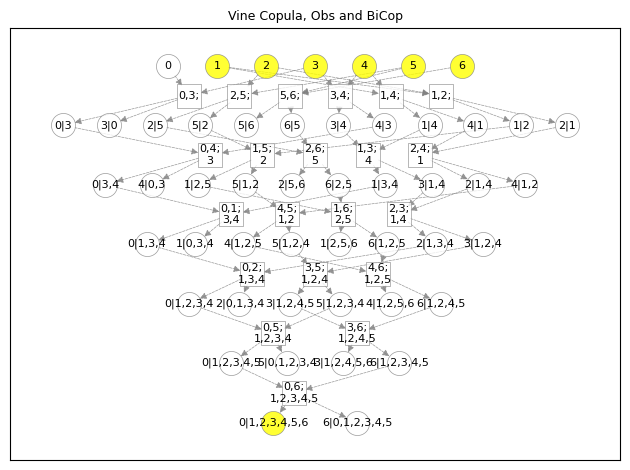

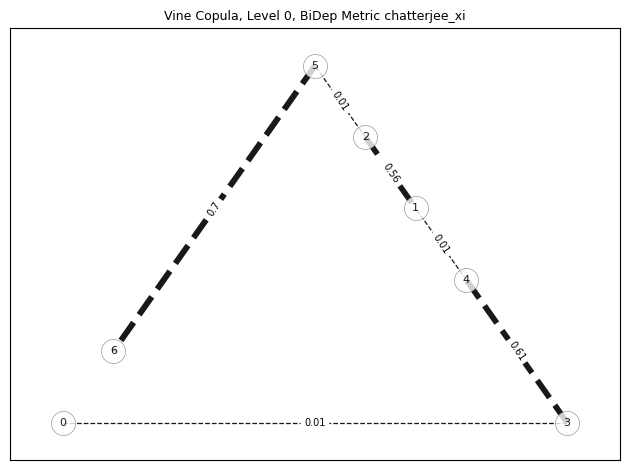

In [6]:
# quant-reg
lst_first = [_ for _ in range(1, NUM_DIM)]
dct_first_vs = {
    (_, frozenset()): torch.ones([NUM_SIM, 1], device=DEVICE) * _ / 10 for _ in range(1, NUM_DIM)
}
dct_first_vs[(0, frozenset(range(1, NUM_DIM)))] = torch.linspace(
    0, 1, NUM_SIM, device=DEVICE
).reshape(-1, 1)
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, cdrvine="dvine", lst_first=lst_first)
print(tvc_mdl)
tvc_mdl.draw_dag(lst_first_vs=dct_first_vs.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs)

### dvine cond sim
> dvine
> 
> suppose we leave `[0,1]` at the deepest lv; specify values for all other vertices.

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 5_000,
 'num_par': 8,
 'negloglik': -12937.1995,
 'aic': -25858.3991,
 'bic': -25806.2615,
 'matrix': '[[ 0  5  6  3  4  2  1]'
           ' [-1  1  5  6  3  4  2]'
           ' [-1 -1  2  5  6  3  4]'
           ' [-1 -1 -1  4  5  6  3]'
           ' [-1 -1 -1 -1  3  5  6]'
           ' [-1 -1 -1 -1 -1  5  6]'
           ' [-1 -1 -1 -1 -1 -1  6]]',
 'lst_sim': [0, 1, 2, 4, 3, 6, 5]}


tensor([[0.9392, 0.3796, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.0674, 0.2851, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.6628, 0.2285, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        ...,
        [0.9284, 0.3088, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.9222, 0.4742, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.0031, 0.1945, 0.2000,  ..., 0.4000, 0.5000, 0.6000]],
       device='cuda:0', dtype=torch.float64)

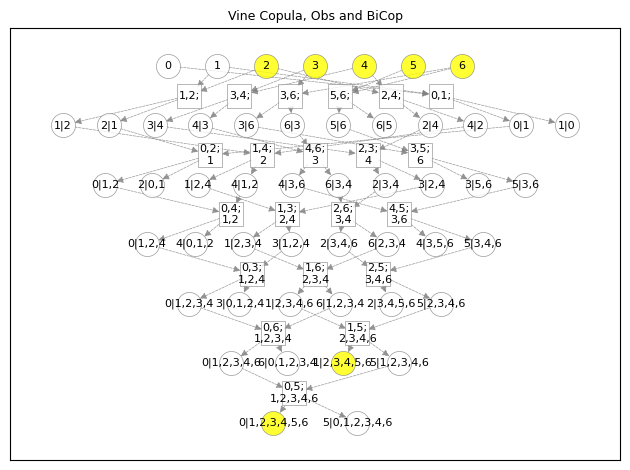

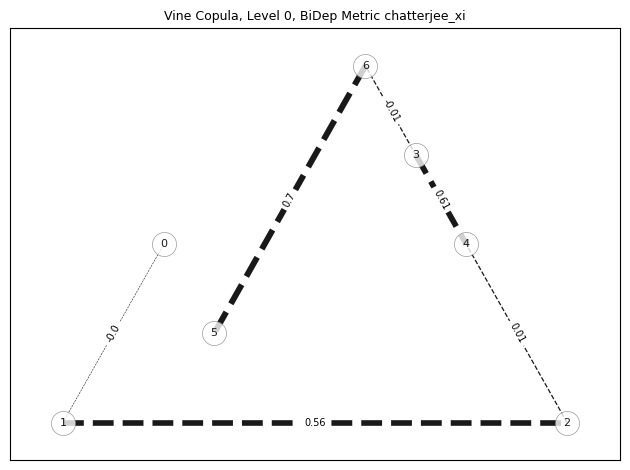

In [7]:
# quant-reg
lst_first = [_ for _ in range(2, NUM_DIM)]
dct_first_vs = {
    (_, frozenset()): torch.ones([NUM_SIM, 1], device=DEVICE) * _ / 10 for _ in range(2, NUM_DIM)
}
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, cdrvine="dvine", lst_first=lst_first)
print(tvc_mdl)
tvc_mdl.draw_dag(lst_first_vs=dct_first_vs.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs)

## rvine

### rvine full sim

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 5_000,
 'num_par': 8,
 'negloglik': -12935.1459,
 'aic': -25854.2918,
 'bic': -25802.1542,
 'matrix': '[[ 0  6  5  1  2  4  3]'
           ' [-1  3  6  5  1  2  4]'
           ' [-1 -1  4  6  5  1  2]'
           ' [-1 -1 -1  1  6  5  2]'
           ' [-1 -1 -1 -1  2  6  5]'
           ' [-1 -1 -1 -1 -1  5  6]'
           ' [-1 -1 -1 -1 -1 -1  6]]',
 'lst_sim': [0, 3, 4, 1, 2, 5, 6]}


tensor([[0.0000, 0.4773, 0.7129,  ..., 0.5677, 1.0000, 0.8805],
        [0.8869, 0.8024, 0.6570,  ..., 0.2553, 0.7065, 0.5873],
        [0.6489, 0.4673, 0.5426,  ..., 0.2569, 0.3445, 0.3703],
        ...,
        [0.9884, 0.4429, 0.3929,  ..., 0.7201, 0.6629, 0.6473],
        [0.6026, 0.4657, 0.4720,  ..., 0.4157, 0.1270, 0.1042],
        [0.1391, 0.2648, 0.4842,  ..., 0.6498, 0.2318, 0.1959]],
       device='cuda:0', dtype=torch.float64)

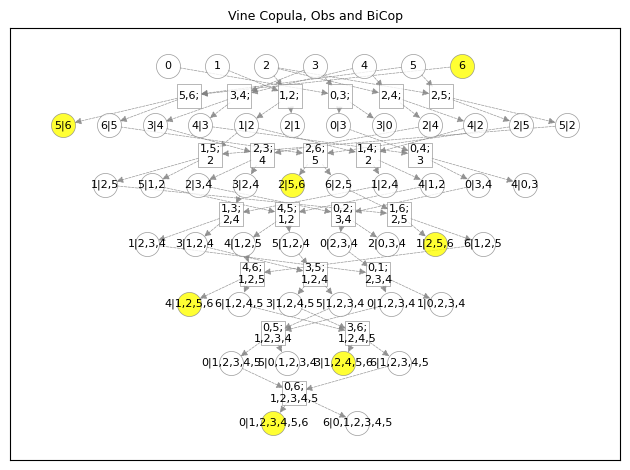

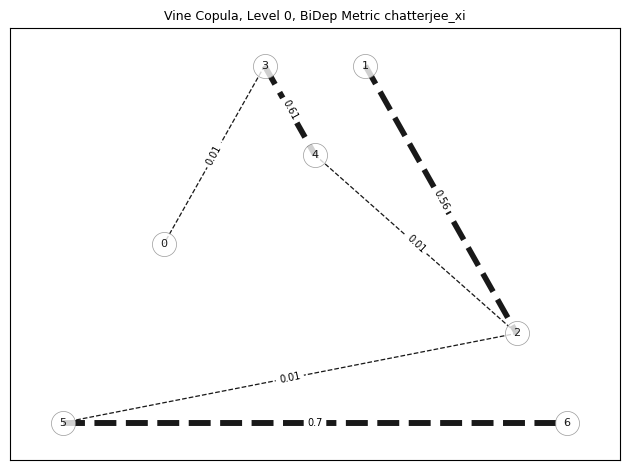

In [8]:
# full sim
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, cdrvine='rvine')
print(tvc_mdl)
tvc_mdl.draw_dag()
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE)

### rvine quant reg
> rvine
> 
> suppose we leave `0` at the deepest lv; specify values for all other vertices and explore its cond quantile from 0 to 1.

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 5_000,
 'num_par': 8,
 'negloglik': -12935.1459,
 'aic': -25854.2918,
 'bic': -25802.1542,
 'matrix': '[[ 0  6  5  1  2  4  3]'
           ' [-1  3  6  5  1  2  4]'
           ' [-1 -1  4  6  5  1  2]'
           ' [-1 -1 -1  1  6  5  2]'
           ' [-1 -1 -1 -1  2  6  5]'
           ' [-1 -1 -1 -1 -1  5  6]'
           ' [-1 -1 -1 -1 -1 -1  6]]',
 'lst_sim': [0, 3, 4, 1, 2, 5, 6]}


tensor([[0.0000e+00, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [2.3913e-04, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [4.6927e-04, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        ...,
        [9.9959e-01, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [9.9980e-01, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01],
        [0.0000e+00, 1.0000e-01, 2.0000e-01,  ..., 4.0000e-01, 5.0000e-01,
         6.0000e-01]], device='cuda:0')

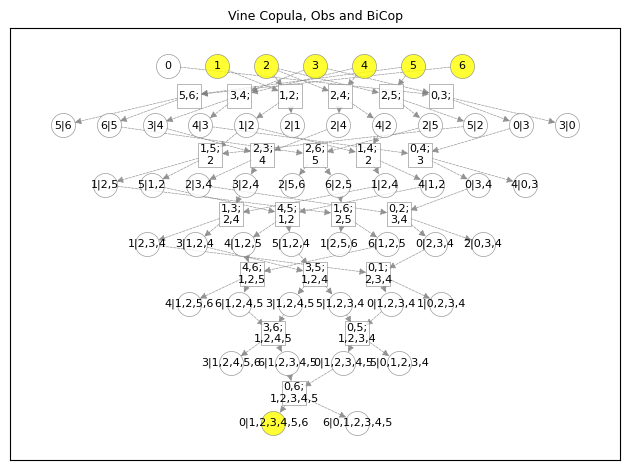

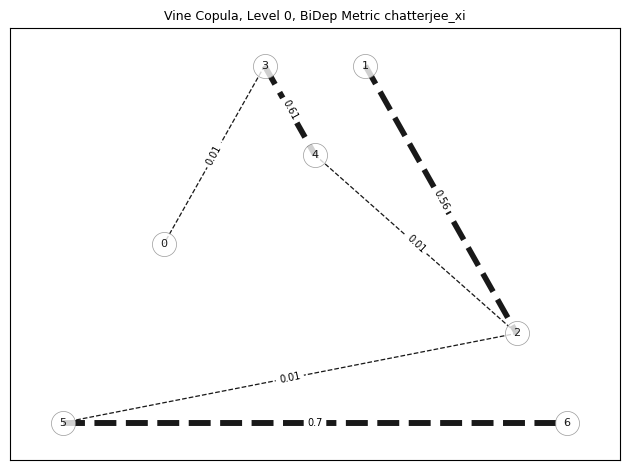

In [9]:
# quant-reg
lst_first = [_ for _ in range(1, NUM_DIM)]
dct_first_vs = {
    (_, frozenset()): torch.ones([NUM_SIM, 1], device=DEVICE) * _ / 10 for _ in range(1, NUM_DIM)
}
dct_first_vs[(0, frozenset(range(1, NUM_DIM)))] = torch.linspace(
    0, 1, NUM_SIM, device=DEVICE
).reshape(-1, 1)
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, cdrvine="rvine", lst_first=lst_first)
print(tvc_mdl)
tvc_mdl.draw_dag(lst_first_vs=dct_first_vs.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs)

### rvine cond sim
> rvine
> 
> suppose we leave `[0,1]` at the deepest lv; specify values for all other vertices.

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 5_000,
 'num_par': 9,
 'negloglik': -12936.1617,
 'aic': -25854.3235,
 'bic': -25795.6688,
 'matrix': '[[ 0  1  6  5  2  4  3]'
           ' [-1  1  3  6  4  5  2]'
           ' [-1 -1  3  6  5  2  4]'
           ' [-1 -1 -1  4  6  5  2]'
           ' [-1 -1 -1 -1  2  6  5]'
           ' [-1 -1 -1 -1 -1  5  6]'
           ' [-1 -1 -1 -1 -1 -1  6]]',
 'lst_sim': [0, 1, 3, 4, 2, 5, 6]}


tensor([[0.9391, 0.3817, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.0696, 0.2865, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.6638, 0.2294, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        ...,
        [0.9284, 0.3103, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.9221, 0.4770, 0.2000,  ..., 0.4000, 0.5000, 0.6000],
        [0.0033, 0.1952, 0.2000,  ..., 0.4000, 0.5000, 0.6000]],
       device='cuda:0', dtype=torch.float64)

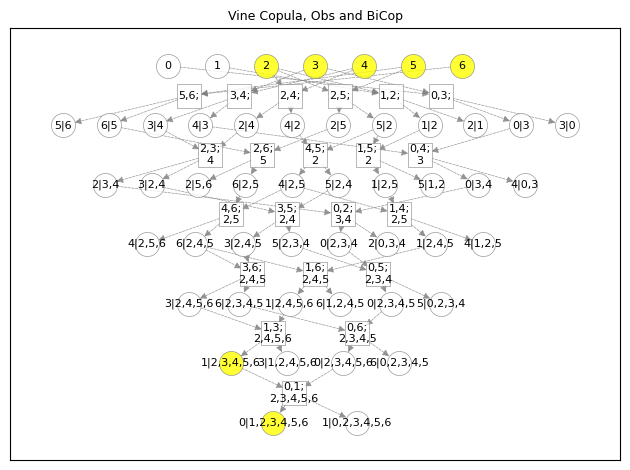

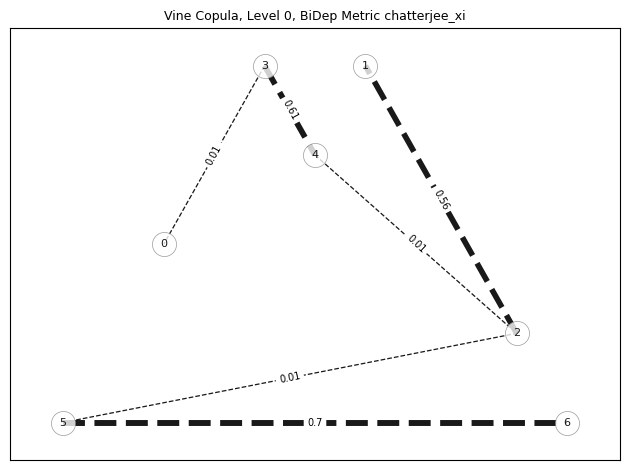

In [10]:
# quant-reg
lst_first = [_ for _ in range(2, NUM_DIM)]
dct_first_vs = {
    (_, frozenset()): torch.ones([NUM_SIM, 1], device=DEVICE) * _ / 10 for _ in range(2, NUM_DIM)
}
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, cdrvine="rvine", lst_first=lst_first)
print(tvc_mdl)
tvc_mdl.draw_dag(lst_first_vs=dct_first_vs.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs)

## lst_sim for experienced users
> `D` Simulation paths starting from `D` pseudo obs vertices at `D` lvs up to corresponding `D` top lv vertices wont intersect at bicop vertices.
> 
> More simulation workflows exist. Experienced users may prefer certain workflow and it's allowed.

tensor([[0.6592, 0.8774, 0.8805,  ..., 0.9397, 0.7129, 0.5652],
        [0.0376, 0.7629, 0.5873,  ..., 0.8924, 0.6570, 0.7548],
        [0.2092, 0.4256, 0.3703,  ..., 0.3868, 0.5426, 0.4953],
        ...,
        [0.4326, 0.9552, 0.6473,  ..., 0.5687, 0.3929, 0.4240],
        [0.0985, 0.1593, 0.1042,  ..., 0.5730, 0.4720, 0.4679],
        [0.5360, 0.0776, 0.1959,  ..., 0.6504, 0.4842, 0.3438]],
       device='cuda:0', dtype=torch.float64)

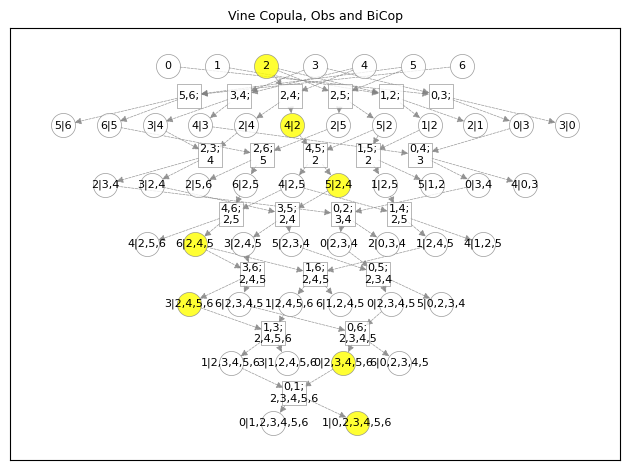

In [13]:
lst_sim = [1,0,3,6,5,4,2]
tvc_mdl.draw_dag(lst_sim=lst_sim)
tvc_mdl.sim(num_sim=NUM_SIM, lst_sim=lst_sim, device=DEVICE)